In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
19261,/home/pascal_steiger/Downloads/data/BEL/img_50...,BEL
3173,/home/pascal_steiger/Downloads/data/IRL/img_52...,IRL
6296,/home/pascal_steiger/Downloads/data/LVA/img_LV...,LVA
25155,/home/pascal_steiger/Downloads/data/DNK/img_DN...,DNK
9338,/home/pascal_steiger/Downloads/data/LTU/img_LT...,LTU
20640,/home/pascal_steiger/Downloads/data/POL/img_PO...,POL
10799,/home/pascal_steiger/Downloads/data/AUT/img_AU...,AUT
19811,/home/pascal_steiger/Downloads/data/EST/img_ES...,EST
19397,/home/pascal_steiger/Downloads/data/BEL/img_50...,BEL
18869,/home/pascal_steiger/Downloads/data/BEL/img_50...,BEL


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
23628  /home/pascal_steiger/Downloads/data/CHE/img_46...   CHE
18519  /home/pascal_steiger/Downloads/data/SVK/img_SV...   SVK
12982  /home/pascal_steiger/Downloads/data/FIN/img_FI...   FIN
18515  /home/pascal_steiger/Downloads/data/SVK/img_SV...   SVK
10824  /home/pascal_steiger/Downloads/data/AUT/img_AU...   AUT
(21234, 2)
                                                    path label
14173  /home/pascal_steiger/Downloads/data/ESP/img_ES...   ESP
16415  /home/pascal_steiger/Downloads/data/BGR/img_BG...   BGR
1598   /home/pascal_steiger/Downloads/data/HRV/img_HR...   HRV
23644  /home/pascal_steiger/Downloads/data/CHE/img_46...   CHE
16785  /home/pascal_steiger/Downloads/data/PRT/img_PR...   PRT
(5309, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [8]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
tl_resnet = ResNet50V2(include_top=True,weights="imagenet")
for layer in tl_resnet.layers:
    layer.trainable = False

for layer in tl_resnet.layers[-3:]:
    layer.trainable = True 
print(tl_resnet.summary())

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [9]:
tl_resnet.layers.pop()
tl_resnet.layers.pop()
tl_resnet.layers.pop()


I = Input(shape=(224, 224, 3))



x = tl_resnet(I)

flat= Flatten()(x)


dense = Dense(4096, activation='relu', name='denserelu')(flat)

dense2 = Dense(2048, activation='relu', name='denserelu2')(dense)

dense3 = Dense(26, activation='softmax', name='my_dense')(dense2)

#prediction = Dense(26, activation='softmax', name='prediction')



#out2 = prediction(x)


new_model2 = tf.keras.Model(I, dense3)

new_model2.summary()





Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1000)              25613800  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
denserelu (Dense)            (None, 4096)              4100096   
_________________________________________________________________
denserelu2 (Dense)           (None, 2048)              8390656   
_________________________________________________________________
my_dense (Dense)             (None, 26)                53274     
Total params: 38,157,826
Trainable params: 14,593,026
Non-trainable params: 23,564,800
________________________________________

In [10]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:0"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-ResNet_v4.h5')

Epoch 1/200
664/664 [==============================] - 372s 552ms/step - loss: 3.0059 - sparse_categorical_accuracy: 0.1291 - val_loss: 2.8229 - val_sparse_categorical_accuracy: 0.1669
Epoch 2/200
664/664 [==============================] - 357s 537ms/step - loss: 2.8109 - sparse_categorical_accuracy: 0.1694 - val_loss: 2.7332 - val_sparse_categorical_accuracy: 0.1874
Epoch 3/200
664/664 [==============================] - 353s 531ms/step - loss: 2.7280 - sparse_categorical_accuracy: 0.1904 - val_loss: 2.6790 - val_sparse_categorical_accuracy: 0.2029
Epoch 4/200
664/664 [==============================] - 353s 532ms/step - loss: 2.6653 - sparse_categorical_accuracy: 0.2065 - val_loss: 2.6427 - val_sparse_categorical_accuracy: 0.2219
Epoch 5/200
664/664 [==============================] - 345s 520ms/step - loss: 2.6124 - sparse_categorical_accuracy: 0.2199 - val_loss: 2.5887 - val_sparse_categorical_accuracy: 0.2366
Epoch 6/200
664/664 [==============================] - 355s 534ms/step - lo

664/664 [==============================] - 352s 530ms/step - loss: 2.0563 - sparse_categorical_accuracy: 0.3638 - val_loss: 2.4152 - val_sparse_categorical_accuracy: 0.2893
Epoch 45/200
664/664 [==============================] - 351s 528ms/step - loss: 2.0435 - sparse_categorical_accuracy: 0.3655 - val_loss: 2.4030 - val_sparse_categorical_accuracy: 0.2903
Epoch 46/200
664/664 [==============================] - 354s 534ms/step - loss: 2.0414 - sparse_categorical_accuracy: 0.3709 - val_loss: 2.4159 - val_sparse_categorical_accuracy: 0.2901
Epoch 47/200
664/664 [==============================] - 352s 530ms/step - loss: 2.0429 - sparse_categorical_accuracy: 0.3671 - val_loss: 2.4143 - val_sparse_categorical_accuracy: 0.2927
Epoch 48/200
664/664 [==============================] - 345s 520ms/step - loss: 2.0355 - sparse_categorical_accuracy: 0.3735 - val_loss: 2.4119 - val_sparse_categorical_accuracy: 0.2950
Epoch 49/200
664/664 [==============================] - 345s 520ms/step - loss: 2.0

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


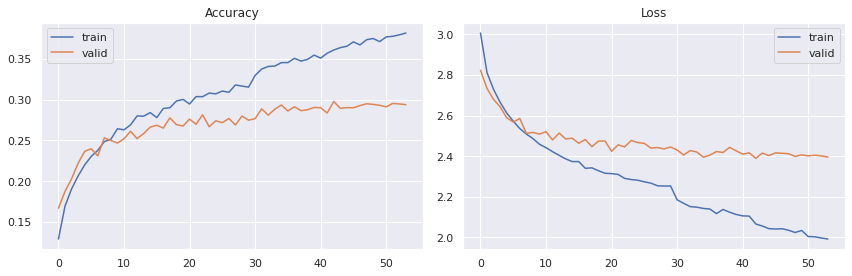

In [12]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN-ResNet_v4.png')

plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = validmodel2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = label2
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

NameError: name 'validmodel2' is not defined